In [37]:
import os
import pickle

import hydra
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from IPython.display import Markdown
from omegaconf import OmegaConf
from tqdm.auto import tqdm

from openretina.cell_type_training import get_movie_meta_dataloader
from openretina.hoefling_2024.configs import model_config
from openretina.hoefling_2024.constants import RGC_GROUP_NAMES_DICT
from openretina.hoefling_2024.data_io import get_all_movie_combinations, natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.metrics import corr_stop3d, correlation_numpy
from openretina.neuron_data_io import filter_responses, make_final_responses
from openretina.utils.h5_handling import load_h5_into_dict

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# load the model config
with hydra.initialize(version_base=None, config_path="../configs"):
    cfg = hydra.compose(
        config_name="minimal_session_agnostic",
        overrides=[
            "data.base_path=/Users/fededagos/PhD_data/fd_export",  # Put here the path to the datasets to load
            "data.save_path=/Users/fededagos/PhD_projects/open-retina/models",  # Here the path to the saved models
        ],
    )

In [6]:
data_path = os.path.join(cfg.data.base_path, "2024-08-14_neuron_data_responses_484c12d_djimaging.h5")
movies_path = os.path.join(cfg.data.base_path, "2024-01-11_movies_dict_c285329.pkl")
responses = load_h5_into_dict(data_path)
movies_dict = pickle.load(open(movies_path, "rb"))
filtered_responses = filter_responses(responses, **OmegaConf.to_object(cfg.quality_checks))  # type: ignore

Loading HDF5 file contents:   0%|          | 0/2077 [00:00<?, ?item/s]

Original dataset contains 7863 neurons over 67 fields
 ------------------------------------ 
Dropped 0 fields that did not contain the target cell types (67 remaining)
Overall, dropped 3034 neurons of non-target cell types (-38.59%).
 ------------------------------------ 
Dropped 0 fields with quality indices below threshold (67 remaining)
Overall, dropped 2587 neurons over quality checks (-53.57%).
 ------------------------------------ 
Dropped 0 fields with classifier confidences below 0.3
Overall, dropped 543 neurons with classifier confidences below 0.3 (-24.22%).
 ------------------------------------ 
Dropped 3 fields with less than 10 responding cells (64 remaining)
Overall, dropped 13 neurons in fields with less than 10 responding cells (-0.77%).
 ------------------------------------ 
Final dataset contains 1686 neurons over 64 fields
Total number of cells dropped: 6177 (-78.56%)


In [7]:
# Load mb_model to extract the training masks
mb_data_info = torch.load(f"{cfg.data.save_path}/2024-10-18_mb_model_data_info.pt")
mb_model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=None, data_info=mb_data_info, seed=42)  # type: ignore
mb_model_weights = torch.load(
    f"{cfg.data.save_path}/2024-10-18_mb_model_model_weights.pt", weights_only=True, map_location="cpu"
)
mb_model.load_state_dict(mb_model_weights)

Random seed 42 has been set.


<All keys matched successfully>

In [8]:
# For the way the gaussian readout is code in the current version, we need a forward pass for the masks to be computed,
# even if loading a model, as they are not directly a parameter but a class attribute.
mb_model.cpu()
mb_model.eval()
with torch.no_grad():
    for session_key in mb_model.readout.keys():
        mb_model(torch.rand(1, 2, 50, 18, 16), session_key)

In [9]:
movie_data_dict = make_final_responses(
    filtered_responses,
    response_type="natural",
    trace_type="spikes",
)
dataloaders = hydra.utils.call(cfg.dataloader, neuron_data_dictionary=movie_data_dict, movies_dictionary=movies_dict)

ct_model = hydra.utils.call(cfg.model, dataloaders=dataloaders, seed=42, readout_mask_from=mb_model)

Upsampling natural spikes traces to get final responses.:   0%|          | 0/64 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/64 [00:00<?, ?it/s]

Random seed 42 has been set.


In [10]:
model_checkpoint = torch.load(
    f"{cfg.data.save_path}/2024-10-18_session_agnostic_model_model_weights.pt", weights_only=True, map_location="cpu"
)
ct_model.load_state_dict(model_checkpoint)

<All keys matched successfully>

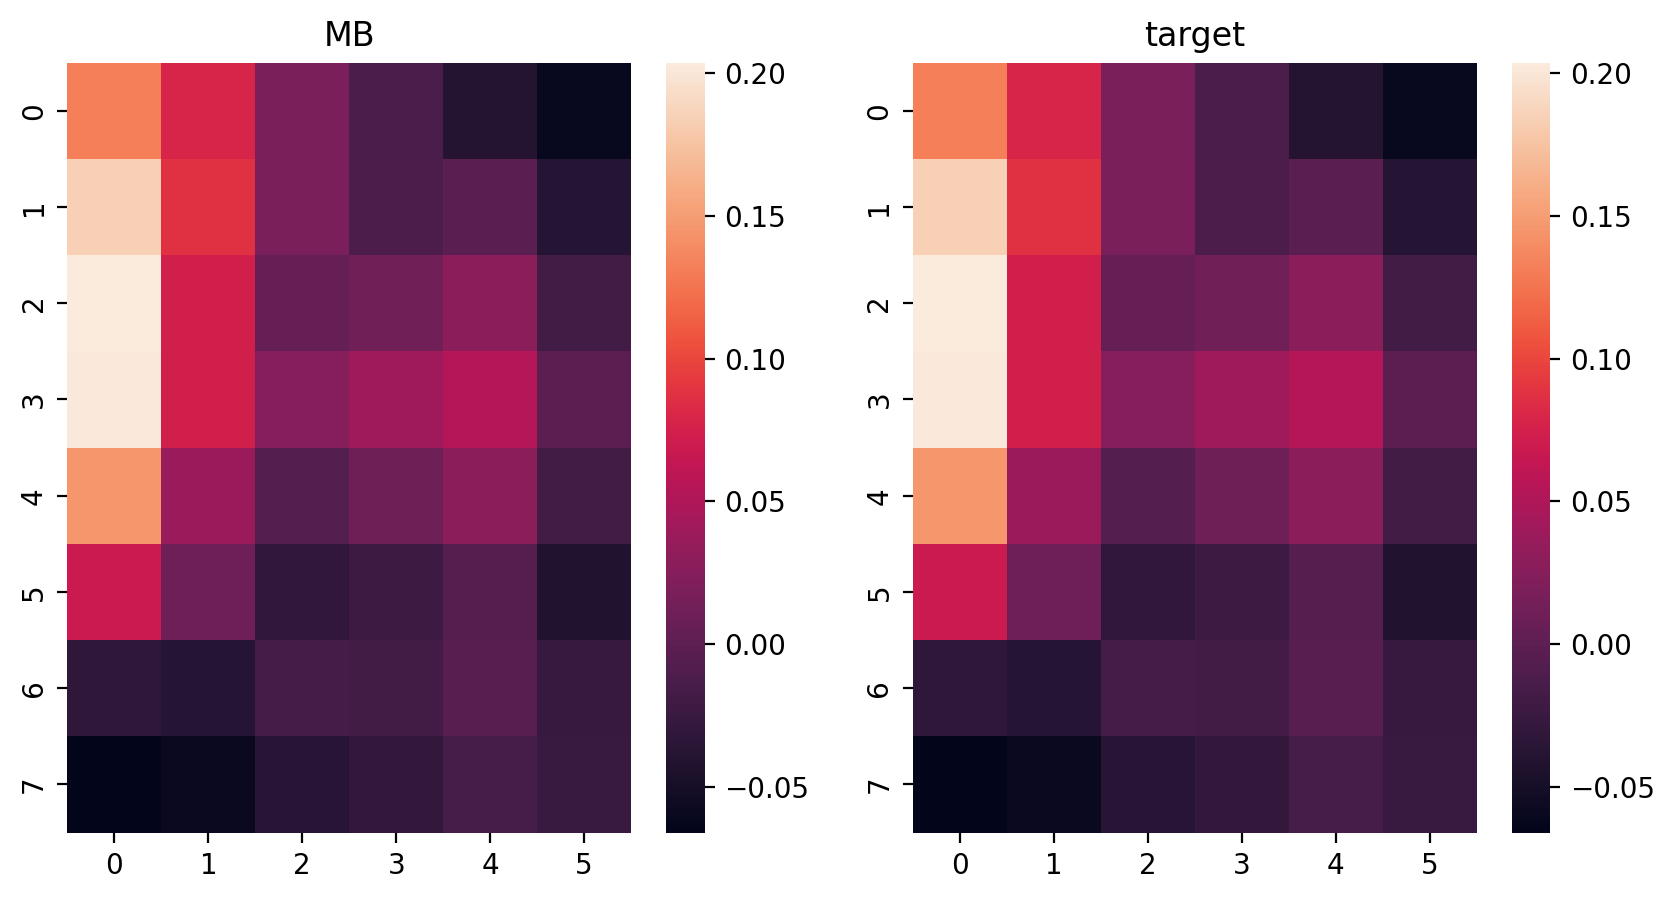

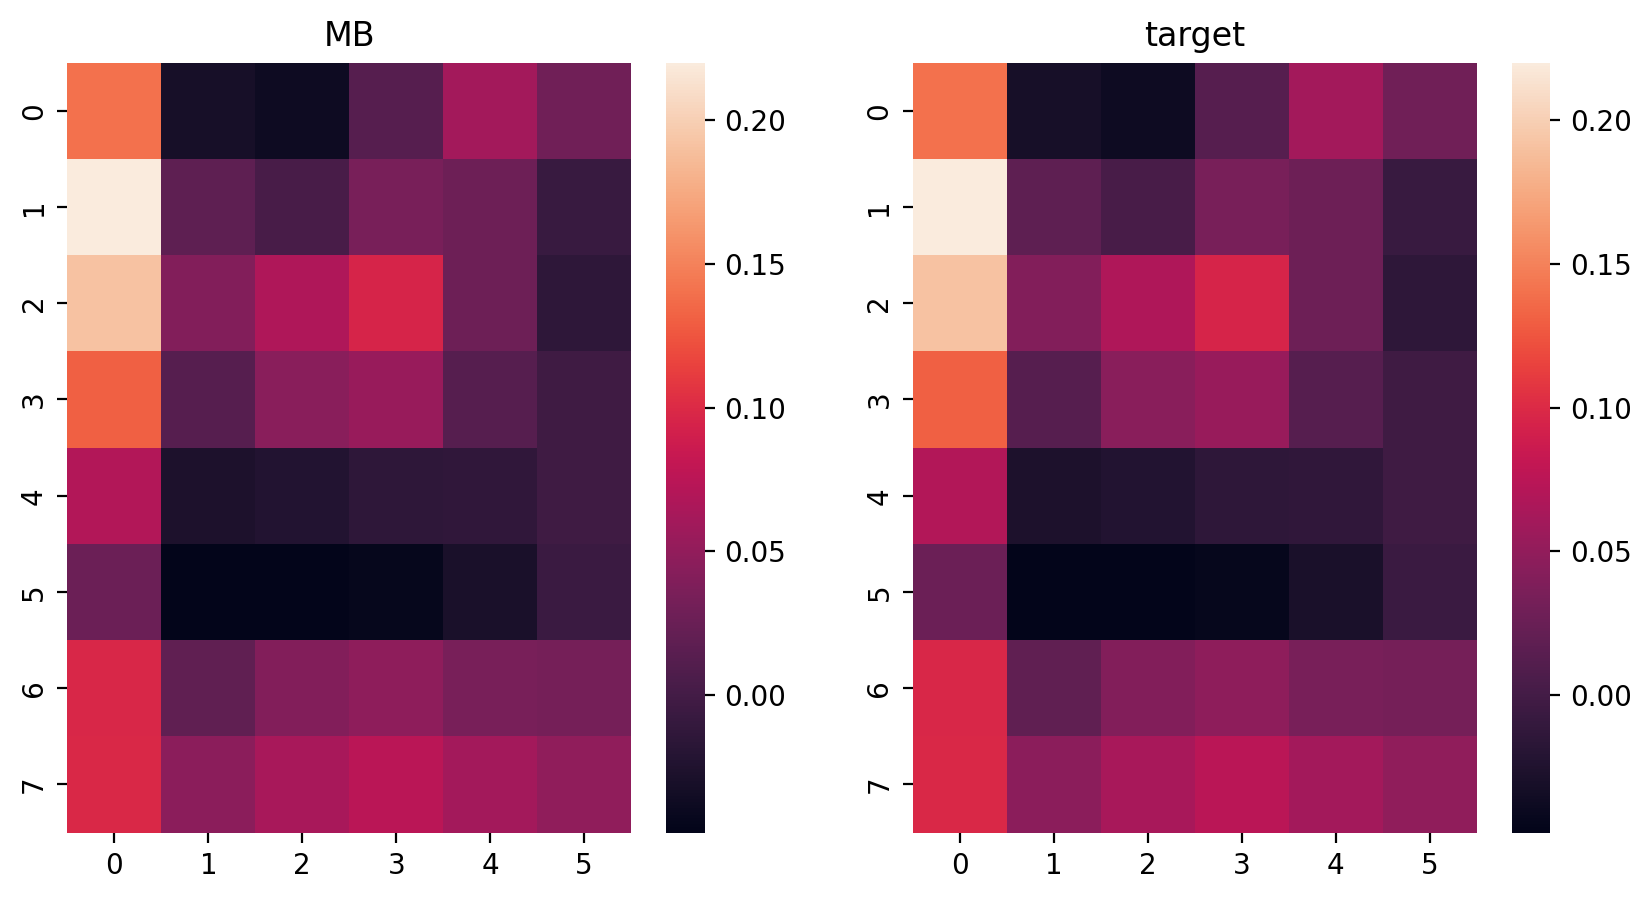

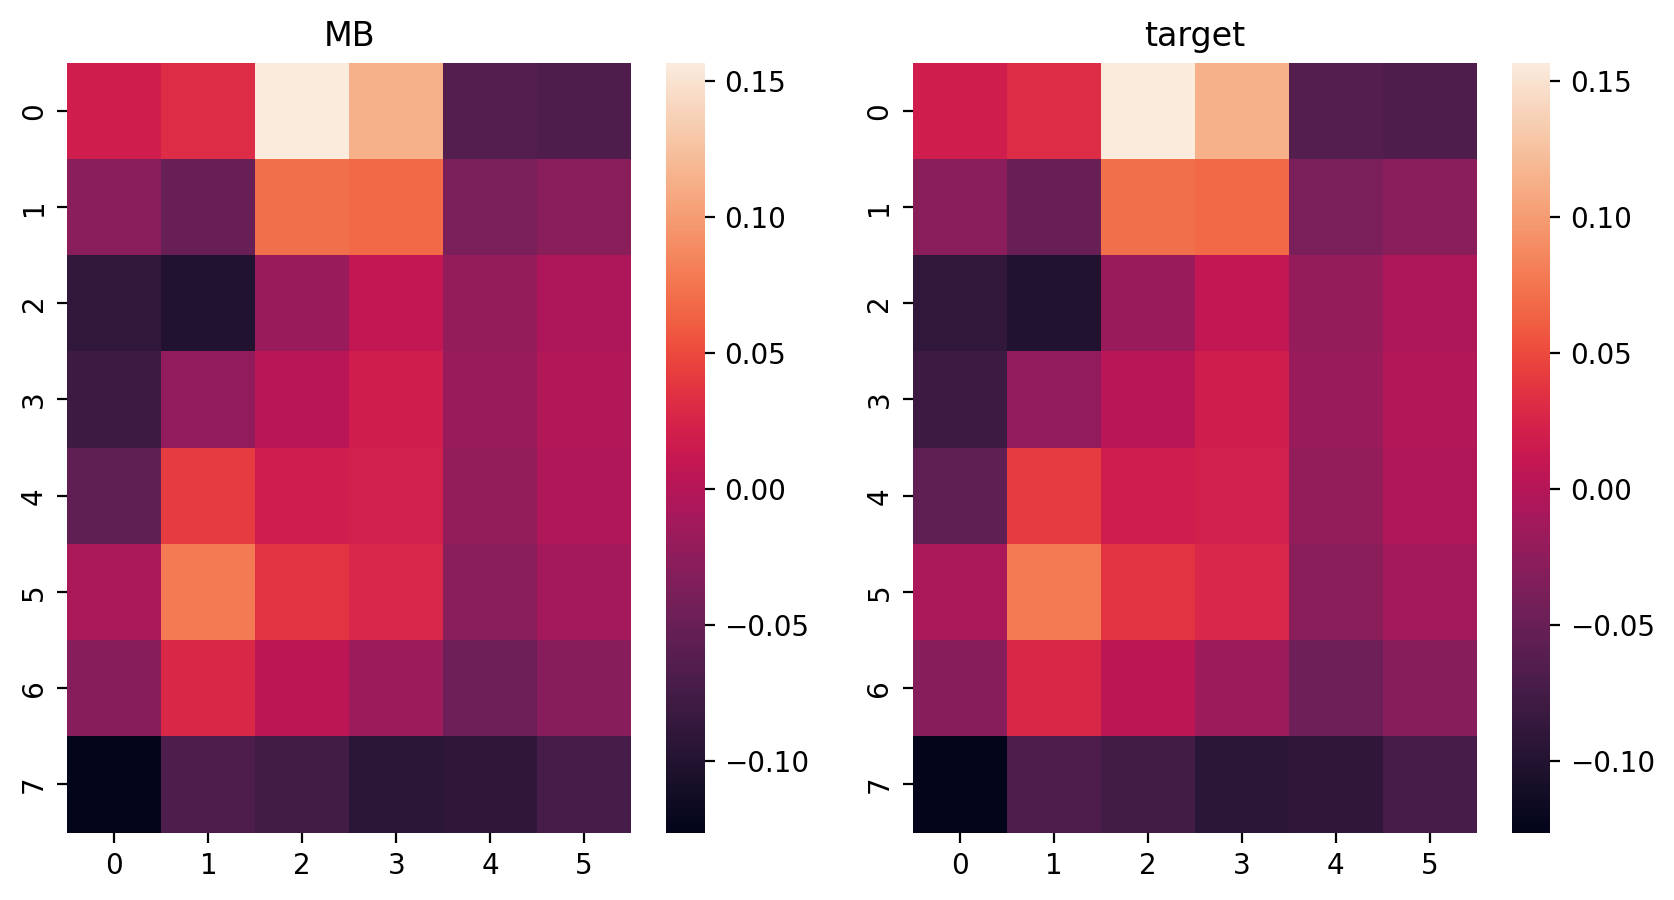

In [11]:
# Check readout mask transfer went successfully
for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(mb_model.readout["session_1_ventral1_20200226_mb"].masks[:, :, i].detach().cpu().numpy(), ax=ax[0])
    sns.heatmap(ct_model.readout_mask_dict["session_1_ventral1_20200226"][:, :, i].detach().cpu().numpy(), ax=ax[1])
    ax[0].set_title("MB")
    ax[1].set_title("target")
    plt.show()

## Model performance

In [12]:
def get_mean_responses(loader, data_key):
    target, mean_resp = torch.empty(0), torch.empty(0)
    for *inputs, responses in loader[data_key]:  # necessary for group assignments
        mean_resp = torch.cat(
            (mean_resp, responses.mean(axis=2).unsqueeze(2).repeat(1, 1, responses.shape[2]).detach().cpu()), dim=0
        )
        target = torch.cat((target, responses.detach().cpu()), dim=0)
    mean_resp = mean_resp.numpy()
    target = target.numpy()
    lag = target.shape[1] - mean_resp.shape[1]

    return target[:, lag:, ...], mean_resp


def corr_to_average(loader, avg: bool = True):
    n_neurons, correlations_sum = 0, 0
    if not avg:
        all_correlations = np.array([])

    for data_key in loader:
        # Usually used when we have a batch dim so we have to unsqueeze it
        target, mean_resp = get_mean_responses(loader, data_key)

        ret = correlation_numpy(target, mean_resp, axis=1)
        ret = ret.mean(axis=0)

        if not avg:
            all_correlations = np.append(all_correlations, ret)
        else:
            n_neurons += mean_resp.shape[-1]
            correlations_sum += ret.sum()

    return correlations_sum / n_neurons if avg else all_correlations

In [13]:
# Load normal_model for performance comparison
normal_data_info = torch.load(f"{cfg.data.save_path}/2024-10-18_hoefling_2024_reproduction_data_info.pt")
normal_model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=None, data_info=normal_data_info, seed=42)  # type: ignore
normal_model_weights = torch.load(
    f"{cfg.data.save_path}/2024-10-18_hoefling_2024_reproduction_model_weights.pt",
    weights_only=True,
    map_location="cpu",
)
normal_model.load_state_dict(normal_model_weights)

no_metadata_dataloader = natmov_dataloaders_v2(movie_data_dict, movies_dict, seed=1000)

Random seed 42 has been set.


Creating movie dataloaders:   0%|          | 0/64 [00:00<?, ?it/s]

In [14]:
# Performance comparison
ct_model_performance = corr_stop3d(ct_model, dataloaders["test"], device="cpu")
normal_model_performance = corr_stop3d(normal_model, no_metadata_dataloader["test"], device="cpu")

mean_trace_corr = corr_to_average(dataloaders["test"])

Markdown(
    f"Session-agnostic model performance on test set: {ct_model_performance:.2f} \n \n"
    f"Normal model performance on test set: {normal_model_performance:.2f} \n"
    "\n \n"
    f"(Oracle mean trace test correlation: {mean_trace_corr:.2f})"
)

Session-agnostic model performance on test set: 0.55 
 
Normal model performance on test set: 0.57 

 
(Oracle mean trace test correlation: 0.51)

## Simulate an arbitrary neuron

In [15]:
def make_mask_grid(w: int, h: int, outdims: int) -> torch.Tensor:
    """Actually mixed up: w (width) is height, and vice versa"""
    grid_w = torch.linspace(-1 * w / max(w, h), 1 * w / max(w, h), w)
    grid_h = torch.linspace(-1 * h / max(w, h), 1 * h / max(w, h), h)
    xx, yy = torch.meshgrid([grid_w, grid_h], indexing="ij")
    grid = torch.stack([xx, yy], 2)[None, ...]
    return grid.repeat([outdims, 1, 1, 1])


def normal_pdf(
    w: int,
    h: int,
    outdims: int,
    mask_log_var: torch.Tensor,
    mask_mean: torch.Tensor,
    gaussian_var_scale: float = 1,
    gaussian_mean_scale: float = 1,
) -> torch.Tensor:
    """Gets the actual mask values in terms of a PDF from the mean and SD."""

    grid = make_mask_grid(w, h, outdims)

    # Calculate scaled log variance
    scaled_log_var = mask_log_var * gaussian_var_scale

    # Clamp values and compute mask variance
    mask_var_ = torch.exp(torch.clamp(scaled_log_var, min=-20, max=20)).view(-1, 1, 1)

    # Compute the PDF based on grid and mask mean
    pdf = grid - mask_mean.view(outdims, 1, 1, -1) * gaussian_mean_scale
    pdf = torch.sum(pdf**2, dim=-1) / (mask_var_ + 1e-8)

    # Exponentiate the clamped PDF values
    pdf = torch.exp(-0.5 * torch.clamp(pdf, max=20))

    # Normalize the PDF
    normalisation = torch.sum(pdf, dim=(1, 2), keepdim=True)
    pdf = torch.nan_to_num(pdf / normalisation)

    return pdf

In [27]:
simulation_example = {
    "invented_session": {
        "cell_types": [1, 5, 24, 30, 31, 32],
        "ds_index": [0] * 6,
        "os_index": [0] * 6,
        "pref_dir": [0] * 6,
        "roi_size_um2": [10] * 6,
        "temporal_nasal_pos_um": [0] * 6,
        "ventral_dorsal_pos_um": [0] * 6,
    }
}
eye = "right"

assert np.all(
    [
        len(v) == len(simulation_example["invented_session"]["cell_types"])
        for v in simulation_example["invented_session"].values()
    ]
)

outdims = len(simulation_example["invented_session"]["cell_types"])

## Compute centered mask
mask_mean = torch.zeros(outdims, 2)
mask_log_var = torch.zeros(outdims)

centered_readout_mask = normal_pdf(w=8, h=6, outdims=outdims, mask_log_var=mask_log_var, mask_mean=mask_mean)

Text(0.5, 1.0, 'Centered readout for arbitrary neuron')

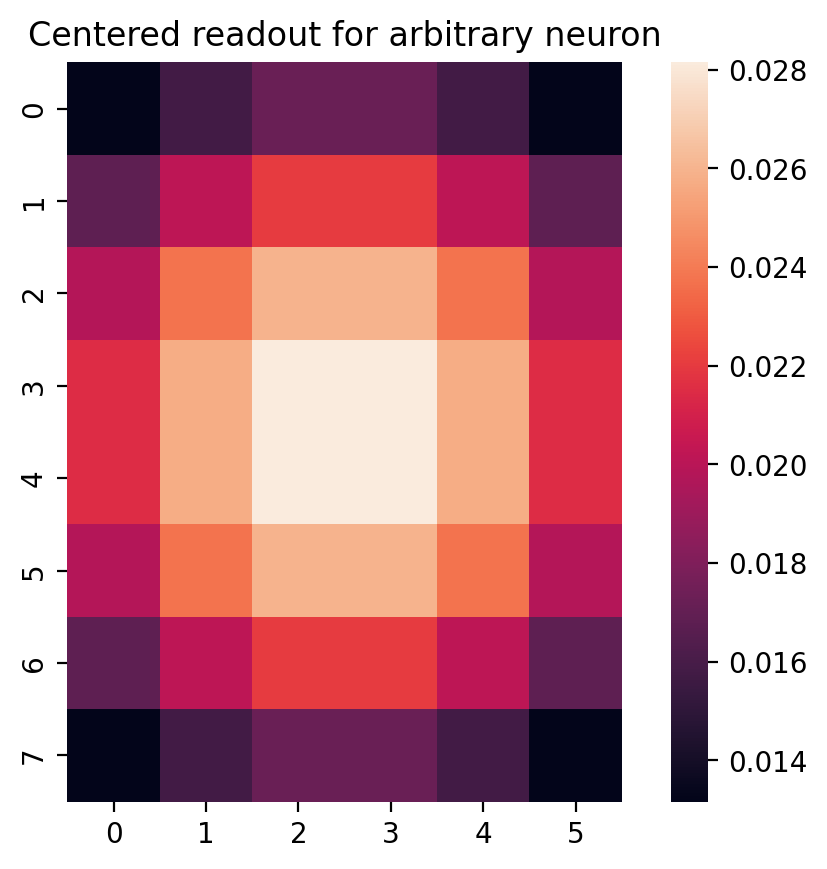

In [17]:
sns.heatmap(centered_readout_mask[0, ...].detach().cpu().numpy(), square=True)
plt.title("Centered readout for arbitrary neuron")

In [34]:
cell_idx = 0
ct_model.eval()
simulated_trace = ct_model.forward(
    x=torch.tensor(movies_dict["test"], dtype=torch.float32).unsqueeze(0),
    categorical_metadata=[torch.tensor(simulation_example["invented_session"]["cell_types"]).unsqueeze(0)],
    numerical_metadata=torch.tensor(
        np.concatenate(
            [
                simulation_example["invented_session"][k]
                for k in simulation_example["invented_session"].keys()
                if k != "cell_types"
            ]
        ).reshape(outdims, -1)
    ).unsqueeze(0),
    data_key=None,
    detach_core=False,
    return_features=False,
    readout_masks=centered_readout_mask.permute(1, 2, 0),
)

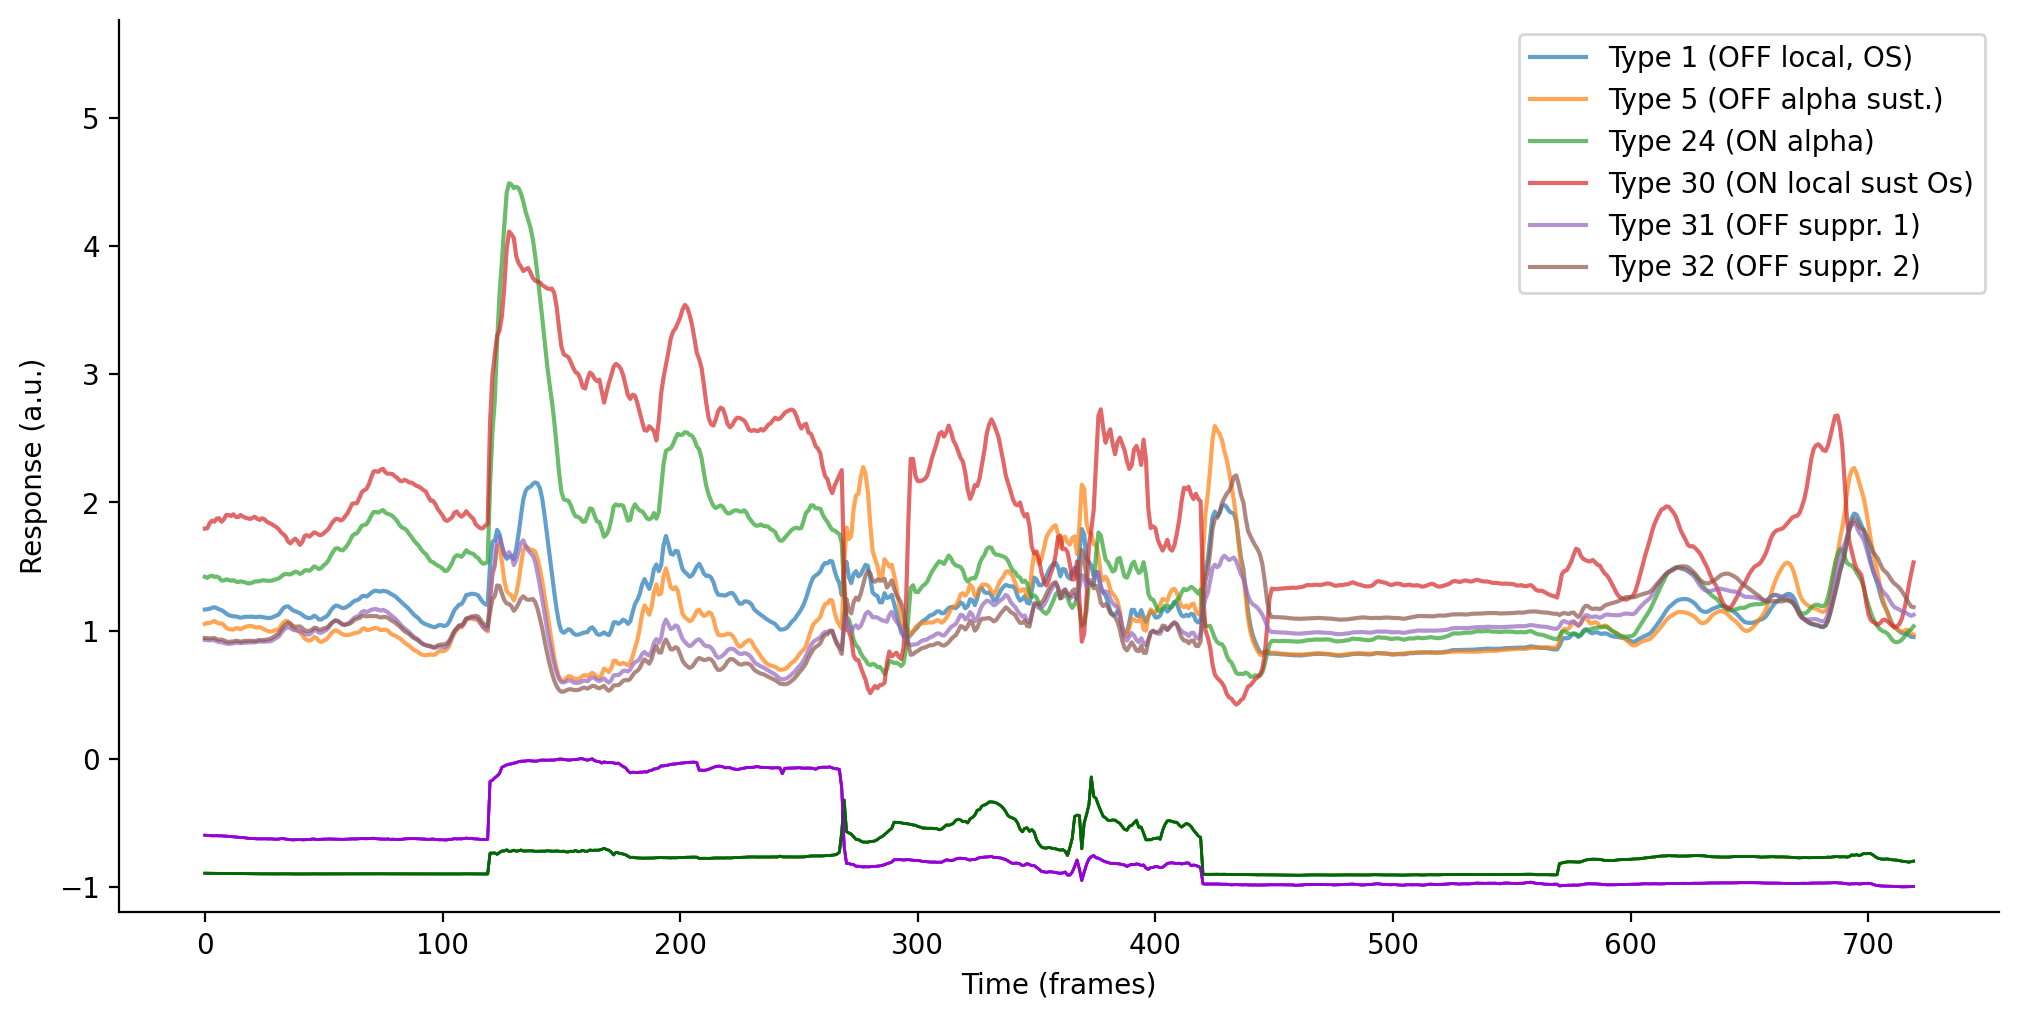

In [48]:
numpy_traces = simulated_trace.squeeze().detach().cpu().numpy().T

plt.figure(figsize=(10, 5))
for i, trace in enumerate(numpy_traces):
    cell_type = simulation_example["invented_session"]["cell_types"][i]
    plt.plot(trace, alpha=0.7, label=f"Type {cell_type} ({RGC_GROUP_NAMES_DICT[cell_type]})")

    spatial_mean = movies_dict["test"].mean(axis=(2, 3))
    green_trace = (spatial_mean[0] - spatial_mean.min()) / (spatial_mean.max() - spatial_mean.min()) - 1
    uv_trace = (spatial_mean[1] - spatial_mean.min()) / (spatial_mean.max() - spatial_mean.min()) - 1
    plt.plot(green_trace[30:], color="darkgreen", linewidth=1, alpha=0.5)
    plt.plot(uv_trace[30:], color="darkviolet", linewidth=1, alpha=0.5)

current_ylim = plt.gca().get_ylim()
plt.ylim(-1.2, current_ylim[1] + 1)
plt.legend()
plt.tight_layout()
plt.xlabel("Time (frames)")
plt.ylabel("Response (a.u.)")
sns.despine()